In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from scipy.optimize import fsolve, minimize
import numpy as np
#import autograd.numpy as np
import math
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import pandas as pd
import csv
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
from pmapper.pharmacophore import Pharmacophore as P
from rdkit.Chem import rdmolops
from pmapper.utils import load_multi_conf_mol
import smogn
import pubchempy as pcp

In [2]:
df_smiles = pd.read_csv('new_list_2.csv', index_col='no')

In [3]:
# RDK fingerprint (daylight)
with open("output_test_2.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = Chem.RDKFingerprint(m, fpSize=2048)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [4]:
# RDK fingerprint (path-based; max_path=7)
with open("output_test_2_path.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = rdmolops.RDKFingerprint(m, fpSize=2048, minPath=1, maxPath=2)
        onbits = list(fp.GetOnBits())[:]
        print(txt, onbits)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

CCCCOCCOCCO [562, 709, 1183, 1308, 1339, 1728, 1772, 1813, 1941, 1960]
C1CCC(=O)NCC1 [112, 166, 412, 709, 802, 993, 1040, 1075, 1105, 1166, 1308, 1772, 1813, 1833, 1907, 2047]
CN(CC(=O)O)C(=N)N [43, 112, 166, 412, 550, 562, 764, 766, 929, 993, 1075, 1105, 1139, 1166, 1183, 1241, 1308, 1339, 1446, 1728, 1772, 1833, 1907, 2047]
C=O [1075, 1907]
CC(C)O [562, 709, 1183, 1308, 1339, 1728, 1772, 1813]
CO [562, 1339]
NC(N)=O [43, 802, 1040, 1075, 1105, 1139, 1907, 2047]
CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O [294, 330, 519, 562, 603, 709, 744, 826, 842, 930, 959, 1026, 1060, 1160, 1183, 1308, 1339, 1342, 1371, 1384, 1400, 1688, 1728, 1772, 1813, 1909]
Oc1ccc(Cl)cc1 [262, 294, 330, 462, 842, 959, 1013, 1026, 1342, 1371, 1400, 1598]
CC(=O)NC1=CC=C(C=C1)O [112, 235, 294, 330, 573, 786, 802, 842, 959, 993, 1026, 1040, 1050, 1075, 1105, 1166, 1308, 1342, 1371, 1400, 1496, 1772, 1774, 1833, 1907, 2047]
CCNC1=NC(=NC(=N1)Cl)NC(C)C [5, 112, 116, 161, 235, 258, 462, 709, 786, 854, 1027, 1050, 1060, 1

In [26]:
# morgan (circular) fingerprint

with open("output_test_2_morgan.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        bi = {}
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=7, nBits=2048, bitInfo=bi) # radius = 2, 4, 6 <-
        onbits = list(fp.GetOnBits())[:]
        print(txt, onbits)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

CCCCOCCOCCO [13, 80, 206, 219, 222, 237, 267, 274, 294, 322, 390, 473, 558, 591, 605, 691, 695, 718, 794, 807, 1057, 1069, 1234, 1325, 1369, 1503, 1540, 1649, 1737, 1911, 1992]
C1CCC(=O)NCC1 [2, 305, 310, 314, 325, 348, 641, 650, 766, 769, 926, 930, 1028, 1072, 1114, 1199, 1302, 1341, 1380, 1506, 1575, 1709, 1738, 1866, 1955]
CN(CC(=O)O)C(=N)N [80, 140, 303, 334, 389, 605, 609, 623, 650, 807, 881, 1057, 1104, 1163, 1171, 1190, 1244, 1474, 1737, 1917, 1950]
C=O [332, 650, 1366]
CC(C)O [1, 227, 283, 709, 807, 1057]
CO [807, 1057, 1155]
NC(N)=O [140, 410, 650, 807, 1171, 1917]
CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O [121, 139, 381, 408, 441, 454, 455, 476, 519, 529, 539, 543, 555, 561, 578, 581, 596, 622, 625, 649, 674, 695, 713, 715, 745, 752, 767, 790, 807, 823, 875, 889, 909, 915, 922, 926, 974, 987, 1019, 1027, 1039, 1054, 1057, 1060, 1073, 1074, 1099, 1134, 1142, 1153, 1154, 1162, 1200, 1236, 1266, 1274, 1285, 1313, 1325, 1372, 1380, 1388, 1436, 1527, 1531, 1602, 1660, 1662, 1738, 1

In [40]:
# Pharm2D (chemical feature and distance) fingerprint

with open("output_test_2_pharm.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = Generate.Gen2DFingerprint(m, Gobbi_Pharm2D.factory)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [106]:
# Pharm3D with Pmapper

with open("output_test_2_pharm.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        mh =Chem.AddHs(m)
        AllChem.EmbedMolecule(mh, randomSeed=42)
        p = P()
        p.load_from_mol(mh)
        temp = p.get_fp(min_features=4, max_features=4, nbits=2048, activate_bits=1)
        temp = list(temp)
        
        arr = np.zeros((1, 2048))
        arr = arr.astype('int')
        df_arr = pd.DataFrame(arr)
        
        for j in zip(temp):
            df_arr.iloc[0][j[0]-1] = 1
        
        wr.writerows([df_arr.iloc[0][:]])
    
    output.close()

In [3]:
# MACCS fingerprint 
with open("output_test_2_MACCS.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = MACCSkeys.GenMACCSKeys(m)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [24]:
# PubChem fingerprint 
with open("output_test_2_PubChem.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = pcp.get_compounds(txt, 'smiles')
        bitstr = m[0].cactvs_fingerprint #bin(int(m[0].fingerprint, 16))
        #m = Chem.MolFromSmiles(txt)
        #fp = MACCSkeys.GenMACCSKeys(m)
        #bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [5]:
df_temp = pd.read_csv('output_test_2.csv', header=None)

In [15]:
df_temp.insert(0, column='0', value=df_smiles['compound'])

In [18]:
df_temp.columns = range(df_temp.columns.size)

In [19]:
df_temp

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,2(2butoxyethoxy)ethanol,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,caprolactam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,creatine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,formaldehyde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,isopropanol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,ampicillin,0,1,0,0,0,0,0,1,1,...,0,1,0,1,1,1,1,1,1,1
226,cephalexinhydrate,0,1,0,1,0,1,1,0,1,...,0,1,0,0,0,1,1,1,0,1
227,diltiazem,0,0,1,1,0,1,1,1,0,...,0,0,0,1,1,1,0,1,1,1
228,erythromycin,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [20]:
df_rej = pd.read_csv('compound_rejections.csv')

df_rej['Types of contaminants'] = df_rej['Types of contaminants'].str.lower()
df_rej['Types of contaminants'] = df_rej['Types of contaminants'].str.replace(' ', '')
df_rej['Types of contaminants'] = df_rej['Types of contaminants'].str.replace('-', '')

In [21]:
df_rej.drop(labels=['ID', 'Type of MB', 'Compound abbreviation', 'Compound Mw (g/mol)', 'Compound charge', 'Compound Kow', 'min projection (A)', 
                    'max projection (A)', 'Measurement time (min)', 'Pressure (kPa)', 'Initial concentration of compound (mg/L)', 'MB zeta potential',
                    'compound size (nm)', 'Total charge', 'reference', 'MWCO ref', 'MB contact angle ref', 'MB zeta potential ref'], axis=1, inplace=True)
df_rej    

,Types of contaminants,pH,MB MWCO (Da),MB contact angle,removal rate (%)
0,2(2butoxyethoxy)ethanol,7.0,150,50.0,81.5900
1,caprolactam,7.0,150,50.0,82.8500
2,creatine,7.0,150,50.0,96.6500
3,formaldehyde,7.0,150,50.0,3.3500
4,isopropanol,7.0,150,50.0,65.2700
...,...,...,...,...,...
1901,indomethacin,7.0,200,22.6,97.0719
1902,cephalexinhydrate,7.0,200,22.6,95.2613
1903,diltiazem,7.0,200,22.6,98.3872
1904,erythromycin,7.0,200,22.6,94.7621


In [22]:
df_rej.describe()

,pH,MB MWCO (Da),MB contact angle,removal rate (%)
count,1906.000000,1906.000000,1906.000000,1906.000000
mean,6.611647,193.015740,51.622959,78.521072
std,1.614833,96.942301,15.359779,26.624313
min,2.200000,65.000000,14.400000,0.000000
25%,7.000000,100.000000,41.400000,72.062500
50%,7.000000,152.000000,53.800000,90.820000
75%,7.000000,300.000000,63.200000,96.900000
max,11.000000,460.000000,79.400000,100.000000


(array([ 61.,  70.,  57.,  66.,  47.,  68.,  71., 175., 301., 990.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

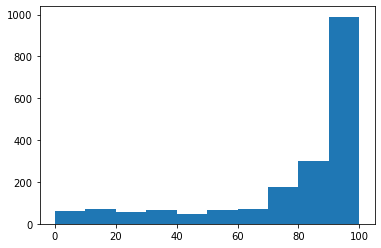

In [30]:
plt.hist(df_rej['removal rate (%)'])

In [35]:
df_fin = pd.DataFrame()

for i in range(len(df_rej)):
    c = df_rej['Types of contaminants'].iloc[i]
    for j in range(len(df_temp)):
        if c == df_temp[0].iloc[j]:
            result = pd.concat([df_rej.iloc[i], df_temp.loc[j][1:]], axis=0)
            df_result = pd.DataFrame(result)
            transposed = df_result.transpose()
            df_fin = pd.concat([df_fin, transposed], axis = 0)

In [32]:
#df_fin.to_csv('df_fin_morgan_2048_6_short.csv')
#df_fin.to_csv('df_fin_MACCS_smogn_ex.csv')
#df_fin.to_csv('df_fin_MACCS_short.csv')
df_fin.to_csv('df_fin_morgan_2048_7_short.csv', index=False)